In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import coremltools
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Dropout, Flatten, Reshape, Conv1D, MaxPooling1D, BatchNormalization, AveragePooling1D
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

/data/miniconda3/envs/python_3.10.x/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-10-31 23:28:42.456306: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 23:28:46.647881: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format # result data will be float with 1 decimal point
sns.set() # Default seaborn look and feel
plt.style.use('ggplot') # set plotting style
print('keras version ', keras.__version__)

# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40

keras version  2.12.0


In [3]:
'''Use this set of labels to train all 7 activities'''
# Same labels will be reused throughout the program
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking',
          'Laying']

In [4]:
# create functions to read data and show information
import pandas as pd
def read_data(file_path):

    column_names = ['user-id',
                    'x-axis',
                    'y-axis',
                    'z-axis',
                    'activity']
    # import data set: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html
    df = pd.read_csv(file_path,
                     delimiter= ',',
                     header= None,                 # column names are passed explicitly so header = none
                     names=column_names,          #List of column names to use
                     lineterminator = '\n')        #lineterminator: break file into lines
                       
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0,                             # determine rows or column to removed (0 = rows, 1 = column)
              how='any',                          # Determine if row or column is removed from DataFrame, when we have at least one NA or all NA. (Any = if one NA value present, drop that row or column)
              inplace=True)                       # Whether to modify the DataFrame rather than creating a new one (true = modified)

    return df

def show_basic_dataframe_info(dataframe):
    print(dataframe.shape)
    
    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))     # .shape[1] = output is no. of column. 
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))      # .shape[0] = output is no. of rows


# Load data set containing all the data from csv
df = read_data('../Data/Raw_WISDM_UCI(laying)_updated.txt') 

# show data
show_basic_dataframe_info(df)
df.tail(20)

(1152954, 5)
Number of columns in the dataframe: 5
Number of rows in the dataframe: 1152954



,user-id,x-axis,y-axis,z-axis,activity
1152934,37,0.1,0.5,0.6,Laying
1152935,37,0.1,0.5,0.5,Laying
1152936,37,0.1,0.5,0.5,Laying
1152937,37,0.1,0.5,0.6,Laying
1152938,37,0.1,0.5,0.5,Laying
1152939,37,0.1,0.5,0.5,Laying
1152940,37,0.1,0.5,0.5,Laying
1152941,37,0.1,0.5,0.6,Laying
1152942,37,0.1,0.5,0.5,Laying
1152943,37,0.1,0.5,0.5,Laying


activity
Walking       424398
Jogging       342179
Upstairs      122869
Downstairs    100427
Sitting        59939
Laying         54747
Standing       48395
Name: count, dtype: int64


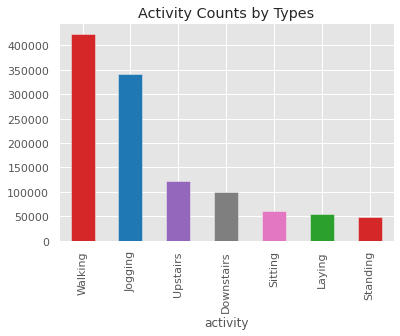

In [5]:
#Show how many training examples exist for each of the six activities
# Show how many training examples exist for each of the six activities
bar_colors = ['tab:red', 'tab:blue', 'tab:purple', 'tab:gray', 'tab:pink', 'tab:green'] # change bar color
value_counts = df['activity'].value_counts()
print(value_counts)
value_counts.plot(kind='bar',
                  title='Activity Counts by Types',
                  color = bar_colors)

plt.show()

In [6]:
# add 1 more column name "activityencoded" to convert each activity into nummerical labels since deep neural network cannot work with non-numerical labels.
# Define column name of the label vector
LABEL = 'ActivityEncoded'

# Transform the labels from String to Integer via LabelEncoder 
# class from scikit-learn used for converting categorizable variable into integer for algorithm that require numerical input data
le = preprocessing.LabelEncoder()          

# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

In [44]:
'''Already did max scale in raw data '''
# def max_scale_round(df):
#     pd.options.mode.chained_assignment = None  # allow to modify the DataFrame or Series using chained indexing without generating a warning. default='warn', none will ignore the warning
#     df['x-axis'] = df['x-axis'] / df['x-axis'].max()
#     df['y-axis'] = df['y-axis'] / df['y-axis'].max()
#     df['z-axis'] = df['z-axis'] / df['z-axis'].max()
#     # Round numbers
#     df = df.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})      #apply rounding to 4 decimal places for the three features (x,y,z) https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.round.html 
#     return df

# round_df = max_scale_round(df)

In [7]:
# reshape data into segments using another function
# This function will take in the dataframe and the label names 
#(the constant that we have defined at the beginning) as well as the length of each record. 
#In our case, let’s go with 80 steps.
# function will also separate the features (x-acceleration, y-acceleration, z-acceleration) and the labels (associated activity).

def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    # get list of unique user
    users = df['user-id'].unique()
    #print(users)
    for id in users:#users:
        sub_df = df[df['user-id']==id]
        for i in range(0, len(sub_df) - time_steps, step):     #obtain value in each axis from each segments
            xs = sub_df['x-axis'].values[i: i + time_steps]
            ys = sub_df['y-axis'].values[i: i + time_steps]
            zs = sub_df['z-axis'].values[i: i + time_steps]
            # Retrieve the most often used label in this segment
            label = stats.mode(sub_df[label_name][i: i + time_steps])[0][0]
            segments.append([xs, ys, zs])
            labels.append(label)
        #print(segments)
        #print(labels)
    # Bring the segments into a better shape
    # np.asarray() create new numpy array from 'segments' list with all elements convert to 'float32' data type
    # .reshaped() reshapes the newly created numpy array into a 3D array with time_steps time steps and N_FEATURES features per time step
    # -1 is inferred by numpy and depends on the size of the original array and the given number of time steps and features. It is used to automatically determine the size of the first dimension to ensure that the reshape operation does not lose any data.
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    print(reshaped_segments)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x, y = create_segments_and_labels(df,
                                    TIME_PERIODS,
                                    STEP_DISTANCE,
                                     LABEL)

[[[-0.0348  0.2512  0.2458]
  [-0.0307 -0.0594  0.069 ]
  [-0.0307 -0.0253 -0.4226]
  ...
  [ 0.3285  0.0722 -0.307 ]
  [-0.3278 -0.0139  0.2264]
  [ 0.0583 -0.1389  0.432 ]]

 [[ 0.284   0.0116 -0.2417]
  [ 0.0922 -0.1652  0.5817]
  [-0.1591  0.0307 -0.3953]
  ...
  [ 0.166   0.0056  0.3049]
  [ 0.0097  0.5682  0.166 ]
  [ 0.0389  0.4084 -0.0194]]

 [[ 0.0212 -0.1789 -0.2342]
  [-0.1072 -0.0669 -0.1461]
  [ 0.1768 -0.2035  0.3803]
  ...
  [-0.1403  0.5043  0.2757]
  [ 0.2382  0.0604 -0.1757]
  [ 0.3792 -0.4549 -0.5626]]

 ...

 [[ 0.0495  0.0627  0.0594]
  [ 0.0693  0.0693  0.0561]
  [ 0.0627  0.0594  0.0693]
  ...
  [ 0.5392  0.5428  0.5439]
  [ 0.5487  0.5428  0.5439]
  [ 0.5416  0.5416  0.538 ]]

 [[ 0.0528  0.0627  0.0561]
  [ 0.0528  0.0726  0.0726]
  [ 0.0693  0.0594  0.0627]
  ...
  [ 0.5451  0.5344  0.5416]
  [ 0.5392  0.5475  0.5344]
  [ 0.5511  0.5368  0.5451]]

 [[ 0.0924  0.0693  0.099 ]
  [ 0.0891  0.0858  0.0924]
  [ 0.0924  0.0858  0.0858]
  ...
  [ 0.5439  0.5344  0.53

In [8]:
# Split data into test set and training set
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42) 

# train_data will contain 80% of the rows
# test_data will contain 20% of the rows

# Print the shapes of the resulting dataframes
print("Train Data Shape:", x_train.shape)
print("Test Data Shape:", x_test.shape)
print("Train_y Data Shape:", y_train.shape)
print("Test_y Data Shape:", y_test.shape)

Train Data Shape: (23014, 80, 3)
Test Data Shape: (5754, 80, 3)
Train_y Data Shape: (23014,)
Test_y Data Shape: (5754,)


<Axes: ylabel='count'>

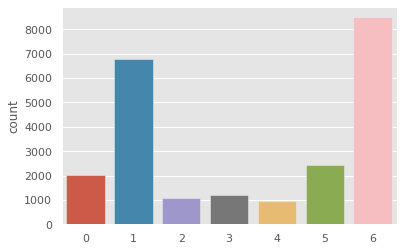

In [9]:
sns.countplot(x=y_train)

<Axes: ylabel='count'>

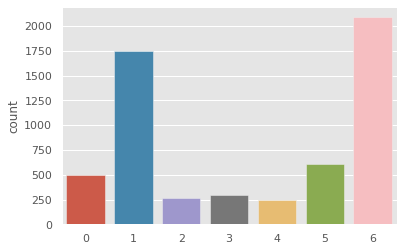

In [10]:
sns.countplot(x=y_test)

In [11]:
# Set input & output dimensions in Deep neural network
# num time period = 80, num sensors = 3 (x,y,z axis)
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
# Number of classes: This is the amount of nodes for our output layer in the neural network. 
num_classes = le.classes_.size 
# property of LabelEncoder(): returns the number of unique categories in the input data that were encoded
# '.classes_ 'returns a sorted array of the unique categories in the input data
# '.size' property returns the length of this array
print(list(le.classes_))

['Downstairs', 'Jogging', 'Laying', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [12]:
# convert 2D data (80x3) into a list of 240 values since Keras and Core ML cannot be used with multi-dimensional input data.
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape) # reshape x_train array into 1D by slicing 20868 samples into various lists containing 240 elements
x_test = x_test.reshape(x_test.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)
print('x_test shape:', x_test.shape)

x_train shape: (23014, 240)
input_shape: 240
x_test shape: (5754, 240)


In [13]:
# convert all feature data (x_train) and label data (y_train) into a datatype accepted by Keras.
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

In [14]:
# perform onehotencoder to convert labels into binary vector (numerical value: in this case 0 to 5 since we have 6 types of activity/labels)
# use to_categorical() function from the keras.utils module to perform one-hot encoding. It takes 2 arguments: 1.catergorical data 2. total num of categories
# also transformed the original array of integer labels into a 2D NumPy array of binary vectors, with one vector for each label.

y_train_hot = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)
y_test_hot = np_utils.to_categorical(y_test, num_classes)
print('New y_test shape: ', y_test_hot.shape)

New y_train shape:  (23014, 7)
New y_test shape:  (5754, 7)


In [16]:
'''Model architecture'''
conv_model = Sequential()
conv_model.add(Reshape((TIME_PERIODS, 3), input_shape=(input_shape,)))   #reshape data from 240 to 80x3 
conv_model.add(Conv1D(filters=32,
                           kernel_size = 3,
                           activation='relu'))
conv_model.add(BatchNormalization())
conv_model.add(Conv1D(filters=32,
                           kernel_size = 3,
                           activation='relu'))
conv_model.add(BatchNormalization())
conv_model.add(MaxPooling1D(pool_size = 2))
conv_model.add(Conv1D(filters=64,
                           kernel_size = 3,
                           activation='relu'))
conv_model.add(BatchNormalization())
conv_model.add(Conv1D(filters=64,
                           kernel_size = 3,
                           activation='relu'))
conv_model.add(BatchNormalization())
conv_model.add(MaxPooling1D(pool_size = 2))
conv_model.add(Conv1D(filters=128,
                           kernel_size = 3,
                           activation='relu'))
conv_model.add(BatchNormalization())
conv_model.add(Conv1D(filters=128,
                           kernel_size = 3,
                           activation='relu'))
conv_model.add(BatchNormalization())
conv_model.add(MaxPooling1D(pool_size = 2))
conv_model.add(Conv1D(filters=256,
                           kernel_size = 3,
                           activation='relu'))
conv_model.add(BatchNormalization())
conv_model.add(Conv1D(filters=256,
                           kernel_size = 3,
                           activation='relu'))
conv_model.add(BatchNormalization())
conv_model.add(MaxPooling1D(pool_size = 2))
conv_model.add(Flatten())
conv_model.add(Dense(24, activation='relu'))
conv_model.add(Dense(24, activation='relu'))
conv_model.add(Dense(24, activation='relu'))
conv_model.add(Dense(num_classes, activation='softmax'))                    # The softmax activation function is commonly used in the output layer of a classification neural network. It converts the output of the previous layer to a probability distribution over the classes. The output values from the softmax function sum to 1, and each value represents the probability that the input belongs to a specific class.
print(conv_model.summary())

2023-07-22 12:13:30.028451: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 80, 3)             0         
                                                                 
 conv1d (Conv1D)             (None, 78, 32)            320       
                                                                 
 batch_normalization (BatchN  (None, 78, 32)           128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 76, 32)            3104      
                                                                 
 batch_normalization_1 (Batc  (None, 76, 32)           128       
 hNormalization)                                                 
                                                                 
 max_pooling1d (MaxPooling1D  (None, 38, 32)           0

In [17]:
''' Caution: need to change name of saved checkpoints everytime '''
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='CNN_allact_updated_2.{epoch:02d}-{val_loss:.2f}.h5',  
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

conv_model.compile(loss='categorical_crossentropy', 
                   optimizer = keras.optimizers.Adam(learning_rate = 0.001), 
                   metrics=['accuracy'])

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = conv_model.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/50
47/47 [==============================] - 5s 56ms/step - loss: 0.6954 - accuracy: 0.7636 - val_loss: 2.2785 - val_accuracy: 0.0993
Epoch 2/50
47/47 [==============================] - 2s 44ms/step - loss: 0.2709 - accuracy: 0.9046 - val_loss: 2.7601 - val_accuracy: 0.1293
Epoch 3/50
47/47 [==============================] - 2s 43ms/step - loss: 0.2071 - accuracy: 0.9337 - val_loss: 2.6498 - val_accuracy: 0.1332
Epoch 4/50
47/47 [==============================] - 2s 43ms/step - loss: 0.1690 - accuracy: 0.9439 - val_loss: 3.6621 - val_accuracy: 0.1295
Epoch 5/50
47/47 [==============================] - 2s 43ms/step - loss: 0.1102 - accuracy: 0.9644 - val_loss: 4.2024 - val_accuracy: 0.0915
Epoch 6/50
47/47 [==============================] - 2s 44ms/step - loss: 0.1368 - accuracy: 0.9538 - val_loss: 4.6933 - val_accuracy: 0.1866
Epoch 7/50
47/47 [==============================] - 2s 44ms/step - loss: 0.1321 - accuracy: 0.9549 - val_loss: 4.0958 - val_accuracy: 0.2342
Epoch 8/50
47

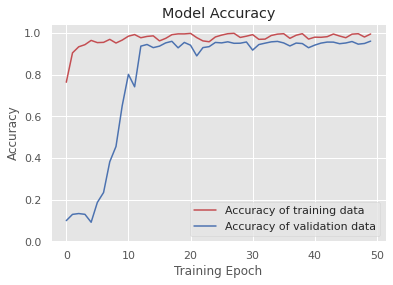

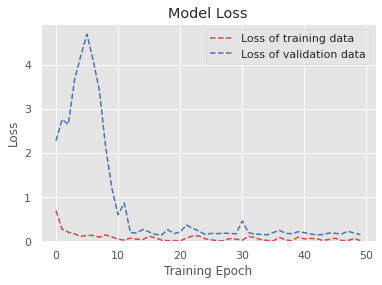

720/720 [==============================] - 3s 4ms/step
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      2016
         1.0       1.00      1.00      1.00      6803
         2.0       1.00      1.00      1.00      1100
         3.0       1.00      0.99      0.99      1200
         4.0       0.99      0.99      0.99       949
         5.0       0.97      0.98      0.97      2445
         6.0       1.00      1.00      1.00      8501

    accuracy                           0.99     23014
   macro avg       0.99      0.99      0.99     23014
weighted avg       0.99      0.99      0.99     23014



In [18]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = conv_model.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

180/180 [==============================] - 1s 4ms/step


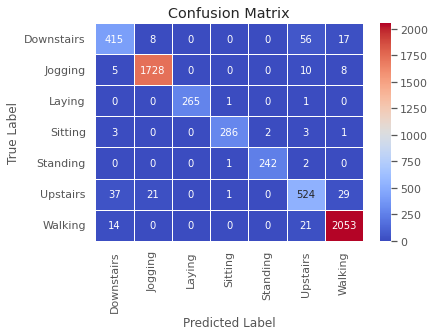

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       496
           1       0.98      0.99      0.99      1751
           2       1.00      0.99      1.00       267
           3       0.99      0.97      0.98       295
           4       0.99      0.99      0.99       245
           5       0.85      0.86      0.85       612
           6       0.97      0.98      0.98      2088

    accuracy                           0.96      5754
   macro avg       0.95      0.94      0.95      5754
weighted avg       0.96      0.96      0.96      5754



In [19]:
def show_confusion_matrix(validations, predictions):
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=le.classes_,                
                yticklabels=le.classes_,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = conv_model.predict(x_test)

# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test_hot, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))